In [867]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [868]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from tqdm.notebook import tqdm

In [869]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [870]:
# hyper parameter
num_classes = 30
close_num = 14 # 14, 19, 24, 29
batch_size = 64
learning_rate = 0.001
num_epochs = 20
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
threshold = 0.8
thresholds = [0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
close_nums = [14, 19, 24, 29]

In [871]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [872]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

labels_series = pd.Series(labels)

In [873]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

5441 900
5262 838
5086 725
4911 1219
4732 507
4497 1107
4321 1244
4147 838
3953 438
3764 1232
3589 788
3406 1150
3234 619
3052 1188
2880 388
2705 1113
2348 1157
2141 1113
1956 1232
1771 532
1588 475
1402 644
1225 1232
1044 482
869 1150
695 1144
523 713
351 713
173 525


((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [901]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        return self.act(self.bn(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2: 
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

    
@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs) # c_in is input channel num of conv1d
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out) # c_out is 1d output size 

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [875]:

summary(model)

Layer (type:depth-idx)                        Param #
InceptionTime                                 --
├─InceptionBlock: 1-1                         --
│    └─ModuleList: 2-1                        --
│    │    └─InceptionModule: 3-1              2,432
│    │    └─InceptionModule: 3-2              77,056
│    │    └─InceptionModule: 3-3              77,056
│    │    └─InceptionModule: 3-4              77,056
│    │    └─InceptionModule: 3-5              77,056
│    │    └─InceptionModule: 3-6              77,056
│    └─ModuleList: 2-2                        --
│    │    └─ConvBlock: 3-7                    384
│    │    └─BatchNorm1d: 3-8                  256
│    └─Add: 2-3                               --
│    └─ReLU: 2-4                              --
├─GAP1d: 1-2                                  --
│    └─AdaptiveAvgPool1d: 2-5                 --
│    └─Flatten: 2-6                           --
├─Linear: 1-3                                 2,064
Total params: 390,416
Trainable para

In [876]:
from tsai.models.utils import count_parameters

In [877]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [878]:
dataset[0][1], dataset[4473][1], dataset[4474][1], dataset[len(dataset)-1][1]

(tensor(0), tensor(15), tensor(15), tensor(15))

In [879]:
dataset[3570][1], dataset[3571][1]

(tensor(15), tensor(15))

In [880]:
dataset[2691][1], dataset[2692][1]

(tensor(14), tensor(15))

Additional processing for Open Set

e.g.
train 0~24

test 0~30

concat

In [ ]:
# indices1 = np.arange(4473)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-24
# indices2 = np.arange(4474, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 25-30
# Unknown_label = close_num + 1

In [ ]:
# indices1 = np.arange(3570)
# dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-19
# indices2 = np.arange(3571, len(dataset))
# dataset2 = torch.utils.data.Subset(dataset, indices2) # 20-30
# Unknown_label = close_num + 1

In [881]:
indices1 = np.arange(2691)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(2692, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
Unknown_label = close_num + 1

In [882]:
train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

train : test = 8 : 2 → 3 : 1で分ける

In [883]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [884]:
train_size = int(0.80 * len(data_series.values))
test_size = len(data_series.values) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size]) # check whether each data and label set is synchronized 
print(f"full: {len(dataset)} -> train: {len(train_set)}, test: {len(test_set)}")

train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=True) # テストでシャッフルしても同じ

full: 5413 -> train: 4330, test: 1083


In [899]:
model = InceptionTime(1, close_num + 1) # 0-?+Unknownを出力
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [900]:
summary(model)

Layer (type:depth-idx)                        Param #
InceptionTime                                 --
├─InceptionBlock: 1-1                         --
│    └─ModuleList: 2-1                        --
│    │    └─InceptionModule: 3-1              2,432
│    │    └─InceptionModule: 3-2              77,056
│    │    └─InceptionModule: 3-3              77,056
│    │    └─InceptionModule: 3-4              77,056
│    │    └─InceptionModule: 3-5              77,056
│    └─ModuleList: 2-2                        --
│    │    └─ConvBlock: 3-6                    384
│    └─Add: 2-3                               --
│    └─ReLU: 2-4                              --
├─GAP1d: 1-2                                  --
│    └─AdaptiveAvgPool1d: 2-5                 --
│    └─Flatten: 2-6                           --
├─Linear: 1-3                                 1,935
Total params: 312,975
Trainable params: 312,975
Non-trainable params: 0

In [886]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    # print(outputs)
    loss = triple_joint_loss(outputs, labels) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_2316/238323891.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)


Epoch [1/`20], Step [12/34], Loss: 2.3162
Epoch [1/`20], Step [24/34], Loss: 1.8957
Epoch [2/`20], Step [12/34], Loss: 1.7961
Epoch [2/`20], Step [24/34], Loss: 1.3678
Epoch [3/`20], Step [12/34], Loss: 1.0068
Epoch [3/`20], Step [24/34], Loss: 0.8341
Epoch [4/`20], Step [12/34], Loss: 0.7358
Epoch [4/`20], Step [24/34], Loss: 0.5303
Epoch [5/`20], Step [12/34], Loss: 0.3512
Epoch [5/`20], Step [24/34], Loss: 0.3697
Epoch [6/`20], Step [12/34], Loss: 0.1974
Epoch [6/`20], Step [24/34], Loss: 0.1585
Epoch [7/`20], Step [12/34], Loss: 0.1799
Epoch [7/`20], Step [24/34], Loss: 0.1287
Epoch [8/`20], Step [12/34], Loss: 0.1307
Epoch [8/`20], Step [24/34], Loss: 0.1386
Epoch [9/`20], Step [12/34], Loss: 0.1119
Epoch [9/`20], Step [24/34], Loss: 0.0635
Epoch [10/`20], Step [12/34], Loss: 0.0535
Epoch [10/`20], Step [24/34], Loss: 0.0496
Epoch [11/`20], Step [12/34], Loss: 0.0500
Epoch [11/`20], Step [24/34], Loss: 0.0393
Epoch [12/`20], Step [12/34], Loss: 0.0400
Epoch [12/`20], Step [24/34],

labelは0-24までだから，学習はいじらなくて大丈夫

testはOpen setの場合，0~24とUnknown label(25)になるから，labelは作り直し

25も出力するようなネットワークにしなきゃだめ

In [887]:
outputs

TensorBase([[ -6.4336,  -1.5183,   0.5130,  -5.1082,  -6.9941,  -2.6780,
              -1.1776,   1.5522,  -1.7948,   6.2123,  -1.9395,  -0.5401,
              -4.5497,  -3.5351,  -2.2860],
            [ -1.4913,  -2.9859,  -4.5138,   4.8139,  -2.4439,  -4.9057,
              -0.2201,  -3.3011,  -4.4565,  -2.6611,  -0.9393,  -0.3866,
              -3.8745,  -1.1412,  -2.3279],
            [ -1.6229,  -4.0550,  -4.5326,   6.2755,  -1.6975,  -5.4679,
              -1.3888,  -3.6175,  -4.2338,  -4.0442,  -1.2633,  -0.6983,
              -3.7948,  -0.2557,  -3.6152],
            [ -6.0697,  -0.8581,  -3.9222,  -2.5167,   3.3610,  -1.3428,
              -4.6518,  -2.5915,  -2.0392,  -8.7913,  -3.8522,  -3.1186,
               1.0881,  -1.1429,  -3.6894],
            [ -3.9762,  -2.4198,  -2.5072,  -6.0143,  -2.5594,  -0.6637,
              -2.2769,  -2.9643,   6.0652,  -1.8854,  -4.5870,  -7.6438,
              -3.2845,  -2.0848,  -0.8696],
            [ -6.0401,  -3.6244,   0.1774,  -7.165

In [ ]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    print(_, predicted, one_hot_labels)

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

/tmp/ipykernel_2316/1821349815.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/mnt/c/Users/grpro/workspace/grad_thesis/InceptionTime/env/lib/python3.9/site-packages/torch/overrides.py:1498: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


TensorBase([0.9706, 0.7207, 0.2602, 0.3923, 0.9998, 0.9972, 0.9931, 0.8302,
            0.4656, 0.9994, 0.9319, 0.4122, 0.8542, 0.9958, 0.9987, 0.9944,
            0.9783, 0.9995, 0.5325, 0.5270, 0.9395, 0.9992, 0.9964, 0.6471,
            0.9039, 0.2772, 0.5925, 0.6326, 0.9940, 0.9998, 0.9991, 0.3964,
            0.3835, 0.7283, 0.9924, 0.6921, 0.5074, 0.2540, 0.6622, 0.9844,
            0.8316, 0.3681, 0.9942, 0.9906, 0.9995, 0.9991, 0.8779, 0.6838,
            0.8849, 0.9994, 0.9211, 0.6789, 0.9985, 0.9967, 0.9980, 0.4673,
            0.9993, 0.6568, 0.3438, 0.9995, 0.7031, 0.2812, 0.9407, 0.9908],
           device='cuda:0') TensorBase([ 1, 15, 15, 15, 13,  3,  9,  8, 15,  3,  0, 15, 12,  2,  0, 11,  5,
             0, 15, 15,  8, 12,  2, 15,  8, 15, 15, 15,  9,  4,  5, 15, 15, 15,
             3, 15, 15, 15, 15,  5,  7, 15,  5, 14, 13,  1, 14, 15, 11,  2,  8,
            15,  7,  9,  7, 15,  0, 15, 15,  6, 15, 15, 10,  9],
           device='cuda:0') tensor([ 1, 15, 15, 15, 13,  3

In [ ]:
predicted_lists[700:], one_hot_labels_list[700:]

(array([ 0, 15,  0, 15, 15, 13,  2,  3,  7,  2,  8, 15, 15,  3, 15,  7,  8,
        10, 15, 10, 11,  6,  7, 15,  6, 15, 15,  6, 15, 14,  3,  7,  5, 15,
        15,  4, 14,  5, 15,  5, 12,  7,  7, 15, 15, 15,  0, 10,  0, 15,  3,
        15, 15, 15, 15, 10,  2, 15,  1,  6, 11,  9,  9,  2,  0,  1, 15, 13,
         0, 14, 13, 15,  0, 10,  7, 15, 15, 15, 15, 15,  0,  9,  5, 15, 15,
         9, 15,  1, 15, 15,  2,  0, 15, 14,  0,  6,  7,  6, 10, 15,  5, 13,
        10, 15,  5, 14,  3,  7, 15, 15,  5, 10,  8, 15, 15,  9, 15,  7,  5,
        15, 15, 15, 10, 15, 11, 15, 15,  7,  9, 10, 15,  5,  7,  8, 15, 10,
        10, 12, 13,  2,  3,  4, 15,  9, 12,  3, 10, 15, 10, 15, 15, 15, 12,
         7, 15,  9, 12,  0,  5, 15, 10,  0, 15, 15, 14, 15,  0, 15,  3, 11,
         0, 12,  0,  7,  9,  6, 15, 15, 15, 15, 11,  8, 15,  7, 14,  4, 10,
         0, 15, 15,  0,  2, 15,  4, 15,  2, 15,  8,  8, 14, 15, 15,  7,  0,
         2, 15,  5,  0, 15, 15, 11,  4,  8,  2, 12, 15,  6, 15, 15, 15,  2,
         2, 

In [ ]:
_

TensorBase([0.4735, 0.5521, 0.9939, 0.9995, 0.4465, 0.5849, 0.3063, 0.9936,
            0.4086, 0.4685, 0.2634, 0.9229, 0.9756, 0.9759, 0.9889, 0.9440,
            0.9997, 0.9971, 0.9241, 0.8479, 0.9997, 0.9968, 0.9969, 0.9994,
            0.7546, 0.9973, 0.6989, 0.4326, 0.9997, 0.4539, 0.9963, 0.9918,
            0.3567, 0.9675, 0.9721, 0.8877, 0.5068, 0.9994, 0.5776, 0.4749,
            0.9891, 0.9995, 0.2415, 0.6620, 0.9816, 0.9778, 0.9998, 0.9782,
            0.9936, 0.9829, 0.9974, 0.9991, 0.9991, 0.8231, 0.9773, 0.9994,
            0.2232, 0.9427, 0.9936, 0.8217], device='cuda:0')

In [ ]:
labels

tensor([ 5, 13,  1,  1, 12,  0,  1,  4,  9, 11, 10, 12,  4,  9, 13,  8,  9,  5,
        11, 10, 12,  1, 14,  0, 14,  4, 14, 14,  4,  4, 14,  2, 11,  4, 11,  7,
         4, 12, 10, 11], device='cuda:0')

array([[ 30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2],
       [  0,  31,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2],
       [  0,   0,  29,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,  36,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,  32,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,  37,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,  32,   0,   0,   0,   0,   0,   0,
          0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0,  33,   0,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,  37,   0,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  41,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   

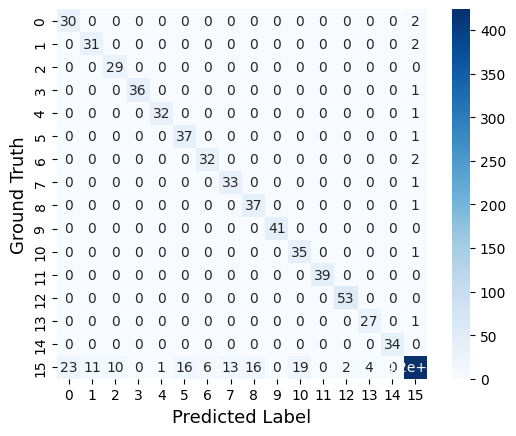

In [908]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)
plt.savefig("./figure/" + fig_name)
cm

In [ ]:
x = np.linspace(0.30, 0.80, 11)
y1 = [86.33, 88.00, 89.94, 91.32, 92.70, 93.26, 93.81, 94.45, 94.92, 94.55, 93.63]
y2 = [71.01, 73.68, 76.55, 78.85, 82.83, 84.03, 85.78, 87.07, 87.72, 88.64, 88.27]
y3 = [55.44, 59.79, 64.76, 70.85, 75.37, 78.41, 80.72, 82.84, 86.25, 87.73, 89.30]
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y1, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y3, marker="x", label="Openness=0.293")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

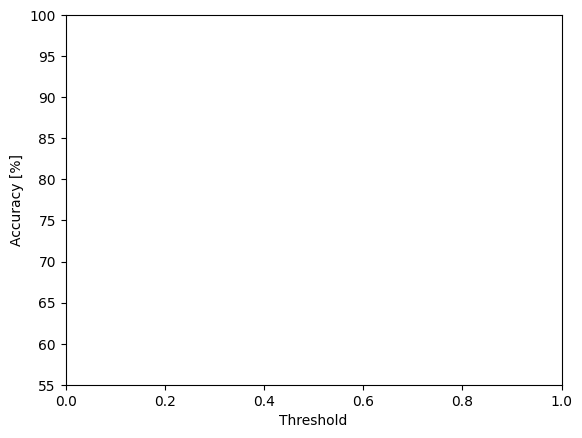

In [909]:
x = np.linspace(0.30, 0.80, 11)
y1 = []
y2 = [71.01, 73.68, 76.55, 78.85, 82.83, 84.03, 85.78, 87.07, 87.72, 88.64, 88.27]
y3 = [55.44, 59.79, 64.76, 70.85, 75.37, 78.41, 80.72, 82.84, 86.25, 87.73, 89.30]
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y1, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y3, marker="x", label="Openness=0.293")
plt.legend()

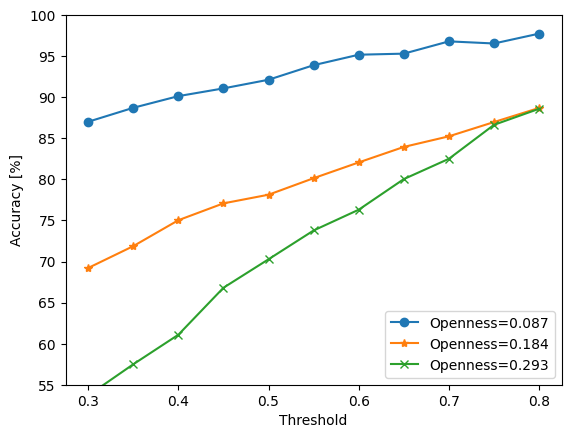

In [910]:
a = np.array([55.35055350553505, 61.99261992619926, 64.11439114391143, 70.75645756457564, 74.6309963099631, 73.5239852398524, 77.58302583025831, 84.5940959409594, 81.91881918819188, 90.59040590405904, 88.46863468634686])
b = np.array([55.71955719557196, 57.564575645756456, 61.62361623616236, 70.9409594095941, 71.58671586715867, 76.56826568265683, 75.27675276752767, 76.19926199261992, 81.2730627306273, 84.96309963099631, 88.00738007380073])
c = np.array([51.93726937269373, 54.7970479704797, 58.025830258302584, 62.08487084870849, 66.32841328413284, 71.03321033210332, 74.72324723247233, 78.50553505535055, 81.91881918819188, 84.77859778597787, 87.82287822878229])
d = np.array([52.859778597785976, 56.91881918819188, 61.254612546125465, 66.14391143911439, 70.84870848708488, 75.46125461254613, 78.87453874538745, 82.10332103321034, 85.05535055350553, 87.63837638376384, 90.59040590405904])
e = np.array([52.5830258302583, 56.18081180811808, 60.42435424354244, 64.11439114391143, 67.98892988929889, 72.32472324723247, 75.09225092250922, 78.78228782287823, 82.380073800738, 85.23985239852398, 88.09963099630997])
ave14 = np.mean([a, b, c, d, e], axis=0)

a1 = np.array([68.88273314866113, 73.40720221606648, 77.65466297322253, 78.67036011080333, 78.76269621421976, 84.57987072945522, 83.28716528162512, 87.44228993536473, 85.96491228070175, 88.9196675900277, 88.73499538319483])
b1 = np.array([69.3444136657433, 71.46814404432133, 76.08494921514313, 78.02400738688827, 78.30101569713759, 76.5466297322253, 83.10249307479225, 83.28716528162512, 87.07294552169898, 87.6269621421976, 90.2123730378578])
c1 = np.array([69.43674976915975, 71.83748845798708, 74.33056325023084, 76.36195752539243, 78.20867959372114, 81.4404432132964, 83.10249307479225, 85.68790397045245, 86.79593721144968, 89.10433979686057, 91.68975069252078])
d1 = np.array([68.69806094182826, 70.3601108033241, 72.11449676823638, 74.42289935364728, 75.53093259464451, 76.73130193905817, 78.02400738688827, 78.76269621421976, 80.33240997229917, 81.80978762696215, 84.11819021237304])
e1 = np.array([69.71375807940905, 72.29916897506925, 74.9769159741459, 77.93167128347184, 79.87072945521699, 81.4404432132964, 82.82548476454294, 84.57987072945522, 86.0572483841182, 87.44228993536473, 88.73499538319483])

ave19 = np.mean([a1, b1, c1, d1, e1], axis=0)

a2 = np.array([88.36565096952909, 91.87442289935365, 91.59741458910435, 93.62880886426593, 92.89012003693445, 93.90581717451524, 96.67590027700831, 95.10618651892891, 98.33795013850416, 95.38319482917821, 97.78393351800554])
b2 = np.array([87.90397045244691, 88.82733148661127, 91.59741458910435, 88.6426592797784, 91.2280701754386, 94.73684210526316, 94.73684210526316, 93.72114496768236, 95.93721144967682, 95.66020313942752, 97.04524469067405])
c2 = np.array([85.87257617728532, 87.53462603878117, 89.47368421052632, 91.59741458910435, 92.05909510618652, 93.25946445060019, 93.8134810710988, 95.01385041551247, 95.8448753462604, 96.67590027700831, 97.96860572483841])
d2 = np.array([86.88827331486611, 88.18097876269621, 89.38134810710989, 90.39704524469067, 91.5050784856879, 92.89012003693445, 94.45983379501385, 95.29085872576178, 96.02954755309327, 96.86057248384118, 97.4145891043398])
e2 = np.array([86.0572483841182, 87.16528162511543, 88.6426592797784, 91.13573407202216, 92.98245614035088, 94.73684210526316, 96.21421975992614, 97.4145891043398, 97.87626962142198, 98.15327793167128, 98.52262234533703])

ave24 = np.mean([a2, b2, c2, d2, e2], axis=0)

x = np.linspace(0.30, 0.80, 11)
y1 = ave14
y2 = ave19
y3 = ave24
y0 = [99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08, 99.08]
plt.ylim(55, 100)
plt.xlabel("Threshold")
plt.ylabel("Accuracy [%]")
# plt.plot(x, y0, label="Openness=0, (threshold=0)")
plt.plot(x, y3, marker="o", label="Openness=0.087")
plt.plot(x, y2, marker="*", label="Openness=0.184")
plt.plot(x, y1, marker="x", label="Openness=0.293")
plt.legend()

最後のfc層の重みとバイアスを使用する
損失関数

In [ ]:
model.fc.weight, model.fc.bias

(Parameter containing:
 tensor([[-0.1783,  0.1674, -0.2028,  ..., -0.0787, -0.1903,  0.0245],
         [-0.0963,  0.1180, -0.0801,  ..., -0.0368, -0.0392, -0.1324],
         [ 0.1636, -0.1728, -0.0747,  ...,  0.0316,  0.1743,  0.1035],
         ...,
         [ 0.1539, -0.1124, -0.0024,  ..., -0.1057, -0.1211, -0.0475],
         [-0.0208, -0.1165,  0.1677,  ..., -0.1203,  0.0778, -0.0227],
         [-0.1342, -0.0169,  0.0269,  ..., -0.0835, -0.0002, -0.0207]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0556, -0.0589, -0.0619,  0.0398,  0.0062, -0.0378, -0.0926, -0.0255,
         -0.0056,  0.0405, -0.0612,  0.0501, -0.0584, -0.0163,  0.0496, -0.0720],
        device='cuda:0', requires_grad=True))

In [890]:
outputs[0], labels

(TensorBase([-6.4336, -1.5183,  0.5130, -5.1082, -6.9941, -2.6780, -1.1776,
              1.5522, -1.7948,  6.2123, -1.9395, -0.5401, -4.5497, -3.5351,
             -2.2860], device='cuda:0', grad_fn=<AliasBackward0>),
 tensor([ 9,  3,  3,  4,  8,  8,  2,  0,  8,  4,  3,  1,  6,  5, 12,  7, 10,  0,
          1,  6, 11,  3, 10,  8,  0,  5,  4, 14,  8, 10,  1,  0,  6,  8,  3,  4,
          9,  6,  5, 10], device='cuda:0'))

In [891]:
from math import log


def softmax_loss(batch_size, softmax_output, labels):
    loss = 0
    for idx in range(batch_size):
        loss += 1.0 - log(softmax_output[labels[idx]])
    return loss / batch_size

In [1]:
from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=2, use_gpu=True)
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.5)

ModuleNotFoundError: No module named 'torch'

In [ ]:
from torch.autograd import Variable
class LMCL_loss(nn.Module):
    """
        Refer to paper:
        Hao Wang, Yitong Wang, Zheng Zhou, Xing Ji, Dihong Gong, Jingchao Zhou,Zhifeng Li, and Wei Liu
        CosFace: Large Margin Cosine Loss for Deep Face Recognition. CVPR2018
        re-implement by yirong mao
        2018 07/02
        """

    def __init__(self, num_classes, feat_dim, s=7.00, m=0.2):
        super(LMCL_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, feat, label):
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        nfeat = torch.div(feat, norms)

        norms_c = torch.norm(self.centers, p=2, dim=-1, keepdim=True)
        ncenters = torch.div(self.centers, norms_c)
        logits = torch.matmul(nfeat, torch.transpose(ncenters, 0, 1))

        y_onehot = torch.FloatTensor(batch_size, self.num_classes)
        y_onehot.zero_()
        y_onehot = Variable(y_onehot).cuda()
        y_onehot.scatter_(1, torch.unsqueeze(label, dim=-1), self.m)
        margin_logits = self.s * (logits - y_onehot)

        return logits, margin_logits

In [ ]:
class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

In [ ]:
def triple_joint_loss():
    return softmax_loss() + center_loss() + cosine_loss()